## Finding Donors for CharityML (Project part of Udacity Machine Learning Nanodegree)

This project is a part of Udacity Machine Learning Nanodegree program. The aim of this project is to classify people's income based on provided demographic characteristics. This is a binary classification task, where we try to predict if a person earns more than $50 000 a year. The InClass Competition can be found here: https://www.kaggle.com/c/udacity-mlcharity-competition. 

### Table of Contents:

1. [Importing Libraries and Data](#import)
2. [Data Exploration](#data_exp)
3. [Transforming Data](#data_transform)
4. [Splitting Data](#data_split)
5. [Model Selection](#model_selection)
6. [Improving Final Model](#imp_final_model)
7. [Predicting Final](#predict_final)
8. [Filling in Missing Values](#miss_values)
9. [Exporting Submission File](#exp_subm)

<a id='import'></a>
### Importing Libraries and Data

First of all, I imported the necessary libraries to manipulate and visualise data. The Training Dataset includes features and labels (income) and the Testing Dataset only includes features. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
train_data = pd.read_csv('census.csv')
test_data = pd.read_csv('test_census.csv')

<a id='data_exp'></a>
### Data Exploration

Before using classification algorithms, we need to understand the data provided and look at the distributions of values for each feature (column). To make plotting easier I wrote two functions: categoric_plot and numeric_plot. The first one outputs a bar plot for a categorical feature and the second one outputs a histogram for a numerical feature.

In [3]:
print('Training dataset has {} rows and {} columns'.format(train_data.shape[0],train_data.shape[1]))

Training dataset has 45222 rows and 14 columns


In [4]:
print('Number of people making more than $50K - {}'.format(train_data['income'].value_counts()[1]))
print('Number of people making less than $50K - {}'.format(train_data['income'].value_counts()[0]))

Number of people making more than $50K - 11208
Number of people making less than $50K - 34014


In [5]:
def categoric_plot(column):
    base_colour = sb.color_palette()[0]
    sb.countplot(data=train_data,x=str(column),color=base_colour)
    plt.xlabel(column.capitalize())
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

def numeric_plot(column):
    data_range = train_data[column].max()-train_data[column].min() 
    bin_edges = np.arange(train_data[column].min(),train_data[column].max()+1,data_range/20)
    plt.hist(data=train_data,x=str(column),bins=bin_edges)
    plt.xlabel(column.capitalize())
    plt.ylabel('Count')
    plt.show()

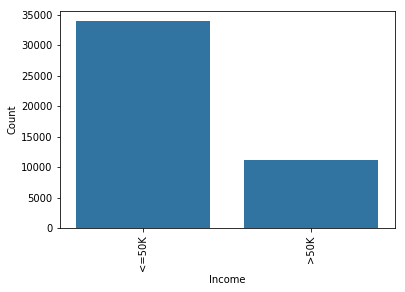

In [6]:
categoric_plot('income')

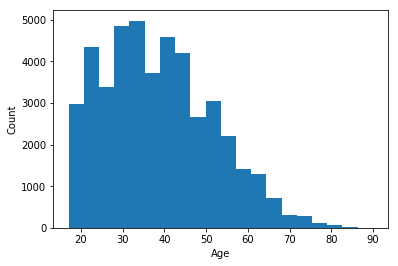

In [7]:
numeric_plot('age')

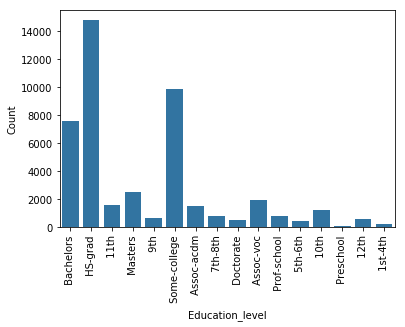

In [8]:
categoric_plot('education_level')

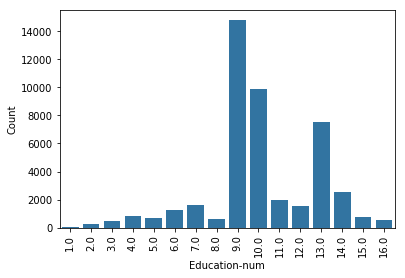

In [9]:
categoric_plot('education-num')

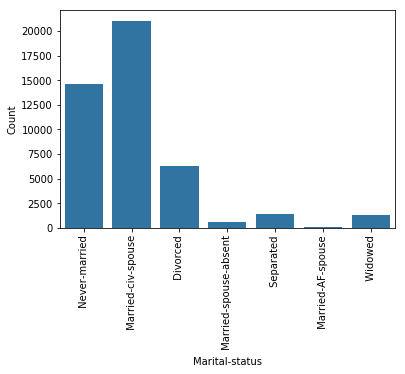

In [10]:
categoric_plot('marital-status')

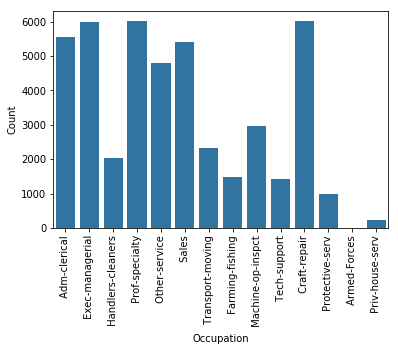

In [11]:
categoric_plot('occupation')

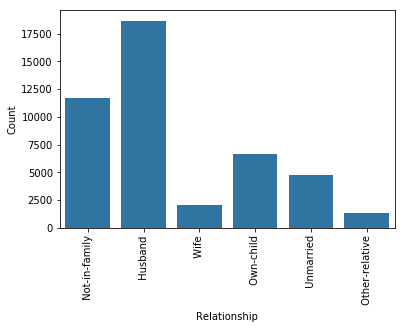

In [12]:
categoric_plot('relationship')

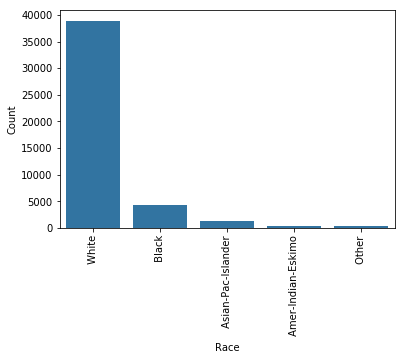

In [13]:
categoric_plot('race')

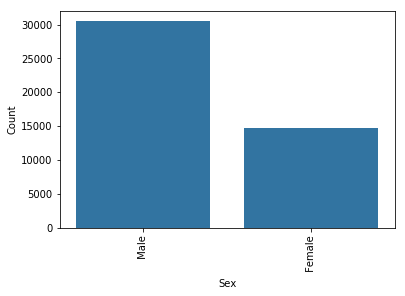

In [14]:
categoric_plot('sex')

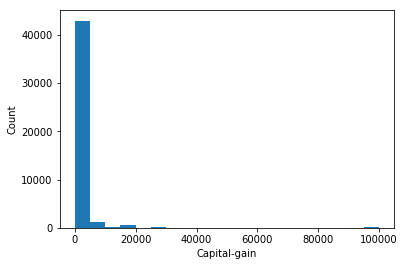

In [15]:
numeric_plot('capital-gain')

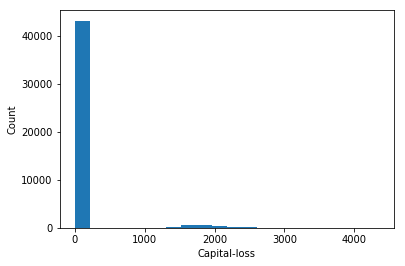

In [16]:
numeric_plot('capital-loss')

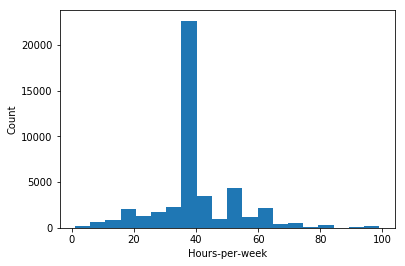

In [17]:
numeric_plot('hours-per-week')

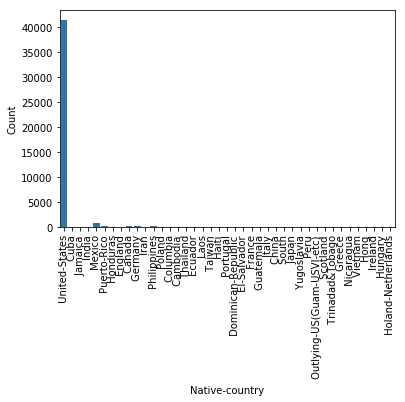

In [18]:
categoric_plot('native-country')

In [19]:
train_data.isnull().sum()

age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

<a id='data_transform'></a>
### Transforming data

After exploring the data, we need to prepare it for training by transforming numerical features using logarithmic scaling and bringing all numeric values to the range of 0 to 1. This will help to reduce the influence of outliers on the performance of our models.

In [20]:
transformed_features = train_data.copy()
transformed_features = transformed_features.drop('income',axis=1)

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

transformed_features[numerical] = scaler.fit_transform(transformed_features[numerical])

C:\Users\Stas\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [22]:
skewed = ['capital-gain', 'capital-loss']
transformed_features[skewed] = transformed_features[skewed].apply(lambda x: np.log(x + 1))

In [23]:
transformed_features = pd.get_dummies(transformed_features)

In [24]:
print('The final training dataset has {} rows and {} columns'.format(transformed_features.shape[0],transformed_features.shape[1]))

The final training dataset has 45222 rows and 103 columns


In [25]:
labels = train_data['income']
labels = labels.map({'<=50K':0,'>50K':1})

<a id='data_split'></a>
### Splitting data

At this stage, we need to split our data into training and testing sets, which can be done with sklearn train_test_split function. By default it splits the data into training and testing in 3:1 ratio (75% and 25% respectively).

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(transformed_features,labels)

<a id='model_selection'></a>
### Model selection

Now, it's time to try out a few models. I imported fbeta_score, accuracy_score and roc_auc_score functions to help evaluate the models. I wrote training function to make this process easier. 

In [34]:
from sklearn.metrics import fbeta_score, accuracy_score, roc_auc_score

def training(X_train,X_test,y_train,y_test,model_choice,sample_size):
    
    model = model_choice
    model.fit(X_train[:sample_size],y_train[:sample_size])
    
    train_pred = model.predict(X_train[:sample_size])
    test_pred = model.predict(X_test)
    
    train_acc = accuracy_score(train_pred,y_train[:sample_size])
    train_fbeta = fbeta_score(train_pred,y_train[:sample_size],beta=0.5)
    train_roc_auc = roc_auc_score(train_pred,y_train[:sample_size])
    
    test_acc = accuracy_score(test_pred,y_test)
    test_fbeta = fbeta_score(test_pred,y_test,beta=0.5)
    test_roc_auc = roc_auc_score(test_pred,y_test)
    
    return train_acc,train_fbeta,test_acc,test_fbeta,train_roc_auc,test_roc_auc,sample_size

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [36]:
DTC001 = training(X_train,X_test,y_train,y_test,DecisionTreeClassifier(),int(X_train.shape[0]*0.01))
DTC010 = training(X_train,X_test,y_train,y_test,DecisionTreeClassifier(),int(X_train.shape[0]*0.10))
DTC100 = training(X_train,X_test,y_train,y_test,DecisionTreeClassifier(),X_train.shape[0])

In [37]:
RFC001 = training(X_train,X_test,y_train,y_test,RandomForestClassifier(),int(X_train.shape[0]*0.01))
RFC010 = training(X_train,X_test,y_train,y_test,RandomForestClassifier(),int(X_train.shape[0]*0.10))
RFC100 = training(X_train,X_test,y_train,y_test,RandomForestClassifier(),X_train.shape[0])

C:\Users\Stas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Stas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Stas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [43]:
KNN001 = training(X_train,X_test,y_train,y_test,KNeighborsClassifier(),int(X_train.shape[0]*0.01))
KNN010 = training(X_train,X_test,y_train,y_test,KNeighborsClassifier(),int(X_train.shape[0]*0.10))
KNN100 = training(X_train,X_test,y_train,y_test,KNeighborsClassifier(),X_train.shape[0])

In [38]:
LR001 = training(X_train,X_test,y_train,y_test,LogisticRegression(),int(X_train.shape[0]*0.01))
LR010 = training(X_train,X_test,y_train,y_test,LogisticRegression(),int(X_train.shape[0]*0.10))
LR100 = training(X_train,X_test,y_train,y_test,LogisticRegression(),X_train.shape[0])

C:\Users\Stas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Stas\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [39]:
ABC001 = training(X_train,X_test,y_train,y_test,AdaBoostClassifier(),int(X_train.shape[0]*0.01))
ABC010 = training(X_train,X_test,y_train,y_test,AdaBoostClassifier(),int(X_train.shape[0]*0.10))
ABC100 = training(X_train,X_test,y_train,y_test,AdaBoostClassifier(),X_train.shape[0])

In [42]:
BC001 = training(X_train,X_test,y_train,y_test,BaggingClassifier(),int(X_train.shape[0]*0.01))
BC010 = training(X_train,X_test,y_train,y_test,BaggingClassifier(),int(X_train.shape[0]*0.10))
BC100 = training(X_train,X_test,y_train,y_test,BaggingClassifier(),X_train.shape[0])

In [45]:
data = [DTC001,DTC010,DTC100,RFC001,RFC010,RFC100,KNN001,KNN010,KNN100,LR001,LR010,LR100,ABC001,ABC010,ABC100,BC001,BC010,BC100]
index = ['Decision Tree Classifier (1%)','Decision Tree Classifier (10%)','Decision Tree Classifier (100%)',
         'Random Forest Classifier (1%)', 'Random Forest Classifier (10%)', 'Random Forest Classifier (100%)',
        'K-Nearest Neighbors (1%)', 'K-Nearest Neighbors (10%)', 'K-Nearest Neighbors (100%)',
         'Logistic Regression (1%)', 'Logistic Regression (10%)', 'Logistic Regression (100%)',
         'AdaBoost (1%)', 'AdaBoost (10%)', 'AdaBoost (100%)',
         'Bagging (1%)', 'Bagging (10%)', 'Bagging (100%)'
        ]
results = pd.DataFrame(data,index=index,columns=['Train_Accuracy','Train_F-beta_Score','Test_Accuracy','Test_F-beta_Score','Train_ROC_AUC','Test_ROC_AUC','Sample_Size'])

In [63]:
results

,Train_Accuracy,Train_F-beta_Score,Test_Accuracy,Test_F-beta_Score,Train_ROC_AUC,Test_ROC_AUC,Sample_Size
Decision Tree Classifier (1%),1.000000,1.000000,0.795153,0.591647,1.000000,0.725617,339
Decision Tree Classifier (10%),0.993807,0.980079,0.804529,0.606730,0.995517,0.737993,3391
Decision Tree Classifier (100%),0.973523,0.925287,0.818415,0.620105,0.975419,0.756873,33916
Random Forest Classifier (1%),0.985251,0.952941,0.808067,0.466877,0.990310,0.754708,339
Random Forest Classifier (10%),0.980537,0.945145,0.832832,0.591657,0.981060,0.783357,3391
Random Forest Classifier (100%),0.962614,0.908654,0.836901,0.623811,0.957174,0.785911,33916
K-Nearest Neighbors (1%),0.864307,0.637255,0.786220,0.488521,0.844432,0.710987,339
K-Nearest Neighbors (10%),0.862577,0.686396,0.812135,0.597646,0.816306,0.748422,3391
K-Nearest Neighbors (100%),0.872184,0.697958,0.822130,0.604496,0.837407,0.763257,33916
Logistic Regression (1%),0.849558,0.620438,0.803556,0.529320,0.816259,0.737957,339


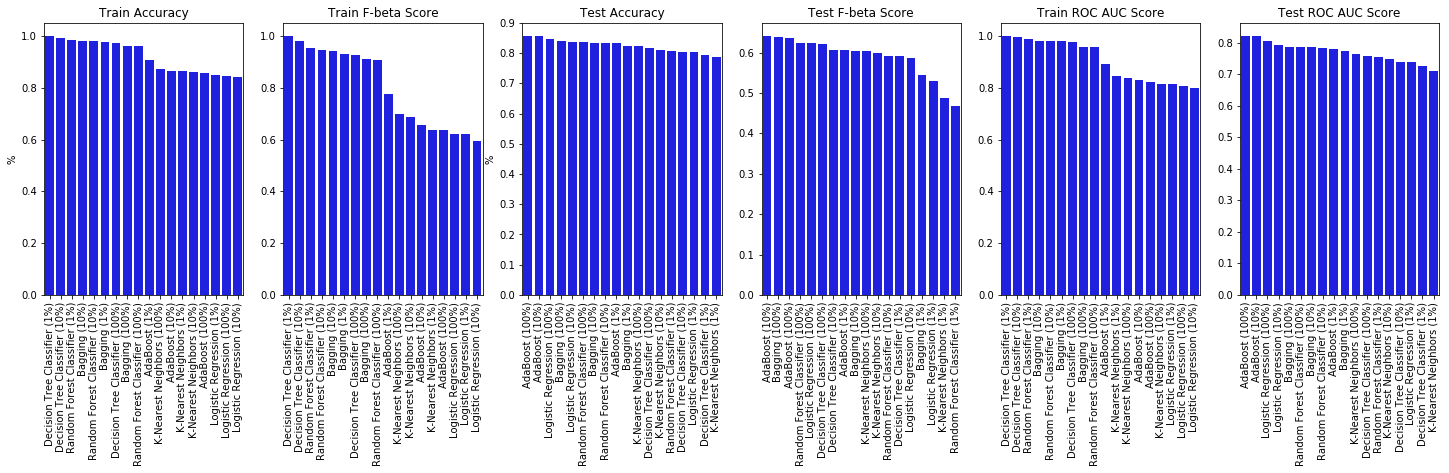

In [48]:
plt.figure(figsize=[25,5])

#clrs = ['blue' if (x < max(values)) else 'red' for x in values ]

plt.subplot(1,6,1)
sb.barplot(x=results['Train_Accuracy'].sort_values(ascending=False).index,y=results['Train_Accuracy'].sort_values(ascending=False).values,palette=clrs)
plt.xticks(rotation=90)
plt.ylabel('%')
plt.title('Train Accuracy')

plt.subplot(1,6,2)
sb.barplot(x=results['Train_F-beta_Score'].sort_values(ascending=False).index,y=results['Train_F-beta_Score'].sort_values(ascending=False).values,palette=clrs)
plt.xticks(rotation=90)
plt.xlabel('')
plt.title('Train F-beta Score')

plt.subplot(1,6,3)
sb.barplot(x=results['Test_Accuracy'].sort_values(ascending=False).index,y=results['Test_Accuracy'].sort_values(ascending=False).values,palette=clrs)
plt.xticks(rotation=90)
plt.ylabel('%')
plt.title('Test Accuracy')

plt.subplot(1,6,4)
sb.barplot(x=results['Test_F-beta_Score'].sort_values(ascending=False).index,y=results['Test_F-beta_Score'].sort_values(ascending=False).values,palette=clrs)
plt.xticks(rotation=90)
plt.xlabel('')
plt.title('Test F-beta Score')

plt.subplot(1,6,5)
sb.barplot(x=results['Train_ROC_AUC'].sort_values(ascending=False).index,y=results['Train_ROC_AUC'].sort_values(ascending=False).values,palette=clrs)
plt.xticks(rotation=90)
plt.xlabel('')
plt.title('Train ROC AUC Score')

plt.subplot(1,6,6)
sb.barplot(x=results['Test_ROC_AUC'].sort_values(ascending=False).index,y=results['Test_ROC_AUC'].sort_values(ascending=False).values,palette=clrs)
plt.xticks(rotation=90)
plt.xlabel('')
plt.title('Test ROC AUC Score')

plt.show()

<a id='imp_final_model'></a>
### Improving the Final Model (AdaBoost)

Based on the results above, I have decided to use AdaBoost Classifier. To tune the hyperparameters I used GridSearch trying out a few possible values of n_estimators parameter.

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = AdaBoostClassifier()

parameters = {'n_estimators':[50,100,200,500,1000]}
scorer = make_scorer(roc_auc_score)
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train,y_train)

C:\Users\Stas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [55]:
final_results = pd.DataFrame(grid_fit.cv_results_)

C:\Users\Stas\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Stas\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Stas\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Stas\Anaconda3\lib\site-packages\sklearn\utils\de

In [56]:
final_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,38.636621,11.559157,3.154680,1.371740,1000,{'n_estimators': 1000},0.796936,0.787403,0.793712,0.792684,0.003959,1,0.798350,0.796110,0.796706,0.797055,0.000947
3,23.724130,1.445596,2.059638,0.359984,500,{'n_estimators': 500},0.796169,0.785559,0.792464,0.791398,0.004397,2,0.797055,0.794601,0.793739,0.795132,0.001405
2,9.153428,0.440026,0.853225,0.179475,200,{'n_estimators': 200},0.791658,0.782470,0.786582,0.786903,0.003758,3,0.792836,0.787980,0.791835,0.790884,0.002093
1,4.429791,0.085556,0.356891,0.019691,100,{'n_estimators': 100},0.786661,0.775556,0.780143,0.780787,0.004556,4,0.784444,0.783388,0.783980,0.783938,0.000432
0,2.341217,0.096445,0.229995,0.018805,50,{'n_estimators': 50},0.778850,0.764659,0.776611,0.773373,0.006229,5,0.771582,0.771614,0.777590,0.773595,0.002825


<a id='predict_final'></a>
### Making final predictions with AdaBoost (n_estimators = 1000) model

Before being able to make predictions on the Test dataset, we need to transform the data in the same manner as we have already done with the Training dataset.

In [57]:
test_data

,Unnamed: 0,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0,21.0,Private,10th,6.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
1,1,49.0,Private,Bachelors,13.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,United-States
2,2,44.0,Self-emp-not-inc,Assoc-acdm,12.0,Married-civ-spouse,Other-service,Wife,White,Female,0.0,0.0,99.0,United-States
3,3,34.0,Private,Bachelors,13.0,Married-civ-spouse,Sales,Husband,White,Male,7298.0,0.0,46.0,United-States
4,4,24.0,Private,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
5,5,52.0,Private,7th-8th,4.0,Divorced,Priv-house-serv,Own-child,Black,Female,0.0,0.0,16.0,United-States
6,6,61.0,Private,7th-8th,4.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,50.0,United-States
7,7,24.0,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
8,8,30.0,Private,HS-grad,9.0,Never-married,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,22.0,United-States
9,9,42.0,Local-gov,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States


In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

test_data[numerical] = scaler.fit_transform(test_data[numerical])

skewed = ['capital-gain', 'capital-loss']
test_data[skewed] = test_data[skewed].apply(lambda x: np.log(x + 1))

test_data = pd.get_dummies(test_data)

In [59]:
test_data = test_data.drop('Unnamed: 0',axis=1)

In [61]:
model = AdaBoostClassifier(n_estimators=1000)
model.fit(transformed_features,labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=1000, random_state=None)

<a id='miss_values'></a>
### Filling in missing values with average values

One of the simplest ways to deal with missing values is just replacing NaNs with the mean values.

In [182]:
test_data['age'][test_data['age'].isnull()] = test_data['age'].mean()

C:\Users\Stas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [183]:
test_data['education-num'][test_data['education-num'].isnull()] = test_data['education-num'].mean()

C:\Users\Stas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [184]:
test_data['capital-gain'][test_data['capital-gain'].isnull()] = test_data['capital-gain'].mean()

C:\Users\Stas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [185]:
test_data['capital-loss'][test_data['capital-loss'].isnull()] = test_data['capital-loss'].mean()

C:\Users\Stas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [186]:
test_data['hours-per-week'][test_data['hours-per-week'].isnull()] = test_data['hours-per-week'].mean()

C:\Users\Stas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<a id='exp_subm'></a>
### Exporting submission file

In [234]:
prediction = model.predict(test_data)

In [235]:
index = np.arange(0,prediction.shape[0],1)

In [236]:
submission = pd.DataFrame(prediction,index=index,columns=['income'])

In [237]:
submission = submission.reset_index()

In [238]:
submission = submission.rename(columns={'index':'id'})

In [239]:
submission.to_csv('submission.csv',index=False)